In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

/opt/homebrew/Caskroom/miniconda/base/envs/subhalos/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [4]:
lgMh_full = np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"]
red_full = np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["redshift"]
halo_masses = np.linspace(8,12,100) # just for the model

def stat_plot_new(thetas, colorpicks):
        
    fig, axes = plt.subplots(4, 4, sharey="row", sharex="row", figsize=(double_textwidth,double_textwidth))

    for ind, theta in enumerate(thetas):

        theta_det = [theta[0], theta[1], theta[2], theta[3], 0.0, 0.0]
        sigma = theta[4] + theta[5]*(halo_masses-12)

        lgMs_full = np.apply_along_axis(jsm_SHMR.general_new, 0, theta, lgMh_full, red_full, 1)
        det = jsm_SHMR.general_new(theta_det, halo_masses, 0, 1)

        for saga_survey in lgMs_full:
            stat = jsm_stats.SatStats_D(saga_survey, min_mass=6.5, max_N=400)
            stack_bins = np.linspace(6.4, 11., 25)
            bin_centers = (stack_bins[:-1] + stack_bins[1:]) / 2
            count_mat = np.apply_along_axis(jsm_stats.count, 1, stat.lgMs, mass_bins=stack_bins)
            stack = np.sum(count_mat, axis=0)
            axes[1, ind].step(bin_centers, stack, color="grey", alpha=0.05, where="mid", lw=0.5)
            axes[1, ind].set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
            axes[1, ind].set_yscale("log")
            axes[1, ind].set_xlim(6.5)

            max_mass_bins = np.linspace(6.4, 10.7, 25)
            counts, bincenters = jsm_stats.count(stat.maxmass, max_mass_bins, return_bins=True)
            axes[2, ind].step(bincenters, counts, where="mid", color="grey", alpha=0.05, lw=0.5)
            axes[2, ind].set_xlabel("$\log M_{*, 1}\ [\mathrm{M}_{\odot}]$")
            axes[2, ind].set_xlim(6.5,10.5)

            Nsat_bins = np.linspace(0, 30, 31)
            counts, bincenters = jsm_stats.count(stat.Nsat_perhost, Nsat_bins, return_bins=True)
            axes[3, ind].step(bincenters, counts, where="mid", color="grey", alpha=0.05, lw=0.5)
            axes[3, ind].set_xlabel("$n_{\mathrm{sat}}$")
            axes[3, ind].set_xlim(0,15)


        lgMh_example = lgMh_full[0]
        lgMs_example = lgMs_full[0]
        stat = jsm_stats.SatStats_D(lgMs_example, min_mass=6.5, max_N=400)

        axes[0, ind].plot(halo_masses, det, color=colorpicks[ind])
        axes[0, ind].fill_between(halo_masses, det - sigma, det + sigma, color=colorpicks[ind], alpha=0.15)
        axes[0, ind].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=colorpicks[ind], alpha=0.1)
        axes[0, ind].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=colorpicks[ind], alpha=0.1)

        above_limit = lgMs_example.flatten() > 6.5
        axes[0, ind].scatter(lgMh_example.flatten()[above_limit], lgMs_example.flatten()[above_limit], marker="*", s=1, color="k")
        axes[0, ind].scatter(lgMh_example.flatten()[~above_limit], lgMs_example.flatten()[~above_limit], marker="*", s=0.5, color="grey")
        axes[0, ind].axhline(6.5, color="grey", ls=":")
        axes[0, ind].set_xlim(9,12)
        axes[0, ind].set_ylim(6.1,10.5)
        axes[0, ind].set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$")

        stack_bins = np.linspace(6.4, 11., 25)
        bin_centers = (stack_bins[:-1] + stack_bins[1:]) / 2
        count_mat = np.apply_along_axis(jsm_stats.count, 1, stat.lgMs, mass_bins=stack_bins)
        stack = np.sum(count_mat, axis=0)
        axes[1, ind].step(bin_centers, stack, color=colorpicks[ind], where="mid")
        axes[1, ind].set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
        axes[1, ind].set_yscale("log")
        axes[1, ind].set_xlim(6.5)

        max_mass_bins = np.linspace(6.4, 10.7, 25)
        counts, bincenters = jsm_stats.count(stat.maxmass, max_mass_bins, return_bins=True)
        axes[2, ind].step(bincenters, counts, where="mid", color=colorpicks[ind])
        axes[2, ind].set_xlabel("$\log M_{*}^{\mathrm{max}}\ [\mathrm{M}_{\odot}]$")
        axes[2, ind].set_xlim(6.5,10.5)

        Nsat_bins = np.linspace(0, 30, 31)
        counts, bincenters = jsm_stats.count(stat.Nsat_perhost, Nsat_bins, return_bins=True)
        axes[3, ind].step(bincenters, counts, where="mid", color=colorpicks[ind])
        axes[3, ind].text(7.5, 20, "$r_{\mathrm{P}} =$"+f"{stat.correlation:.3f}",  bbox=dict(facecolor='white', alpha=1, edgecolor=colorpicks[ind]))
        axes[3, ind].set_xlabel("$n_{\mathrm{sat}}$")
        axes[3, ind].set_xlim(0,15)

        if ind == 0:
            axes[0, ind].set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
            axes[1, ind].set_ylabel("$ N_{\mathrm{stacked}}$")
            axes[2, ind].set_ylabel("$N_{\mathrm{host}}$")
            axes[3, ind].set_ylabel("$N_{\mathrm{host}}$")
            axes[0, ind].set_xticks([8.5, 9.5, 10.5, 11.5])
            axes[0, ind].set_yticks([6, 7, 8, 9, 10])
            axes[1, ind].set_xticks([7, 8, 9, 10, 11])
            axes[2, ind].set_xticks([7, 8, 9, 10, 11])             
            axes[2, ind].set_yticks([0, 5, 10, 15, 20])
            #axes[3, ind].set_yticks([0, 5, 10, 15, 20])              
            axes[3, ind].set_xticks([0, 5, 10, 15])             

    plt.tight_layout()
    plt.savefig("../../../paper_1/figures/feature_recovery/stat_freedom.pdf", bbox_inches="tight")
    plt.show()

In [5]:
new_colors = ["olivedrab", "tomato", "peru", "orchid"]
theta_picks = [[10.5, 2.01, 0.0, 0.0, 0.33, 0.0], [10.5,  1.41833432, -0.26605046,  0.0,  0.22950717,0.0], [1.05000000e+01, 1.95386648e+00, 8.03348913e-05, 0.00000000e+00, 2.13869347e-02, 0.00000000e+00], [10.5,3.0422462 ,0.30028834,  0.,  1.24455193,0.]]

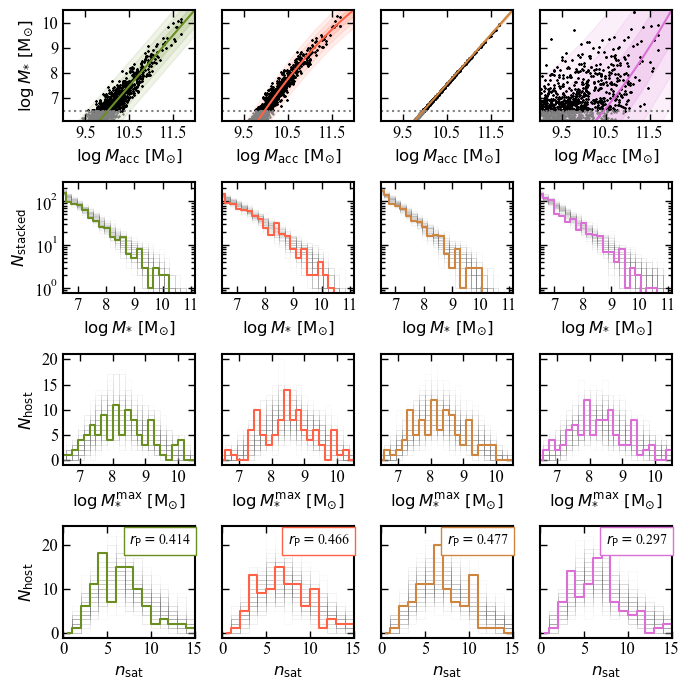

In [6]:
stat_plot_new(theta_picks, new_colors)

In [7]:
fixed = [False, True, False, True, True, False]

#gamma = jsm_mcmc.Chain("../../mcmc/fiducial/extra_freedom/model_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)
#gamma = jsm_mcmc.Chain("../../../data/remote_pull/extra_freedom/model_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)
gamma = jsm_mcmc.Chain("../../../data/remote_pull/model_1_first/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

gamma_free = jsm_mcmc.Chain("../../../data/remote_pull/model_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

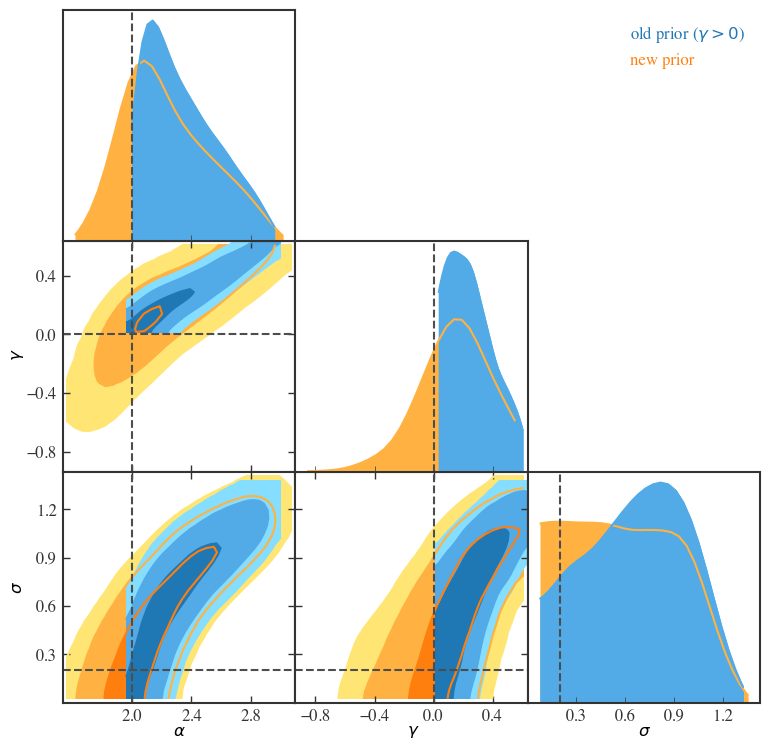

In [8]:
chain_labels = ["old prior ($\\gamma > 0$)",
                "new prior"]


data = [gamma.clean, gamma_free.clean]
test = jsm_mcmc.MulitChain(data, chain_labels, fixed)
test.plot_posteriors(paper=False, filledPlots=True, nContourLevels=3, smoothingKernel=2, truths=[2.0, 0.0, 0.2])

In [9]:
fixed = [False, True, False, False, True, False]

standard = jsm_mcmc.Chain("../../mcmc/simple_power_law/s15/alpha_permutations/mock_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=30)

fixed = [False, True, True, False, True, False]

beta = jsm_mcmc.Chain("../../mcmc/fiducial/extra_freedom/model_0/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

fixed = [False, True, False, True, True, False]

gamma = jsm_mcmc.Chain("../../../data/remote_pull/model_1/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

fixed = [False, True, False, False, True, True]

nu = jsm_mcmc.Chain("../../mcmc/fiducial/extra_freedom/model_2/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

fixed = [True, True, False, False, True, False]

anchor = jsm_mcmc.Chain("../../mcmc/fiducial/extra_freedom/model_3/chain.h5", fixed=fixed, Nstack=500, Nburn=100, Nthin=15)

In [14]:
import matplotlib.patches as patches

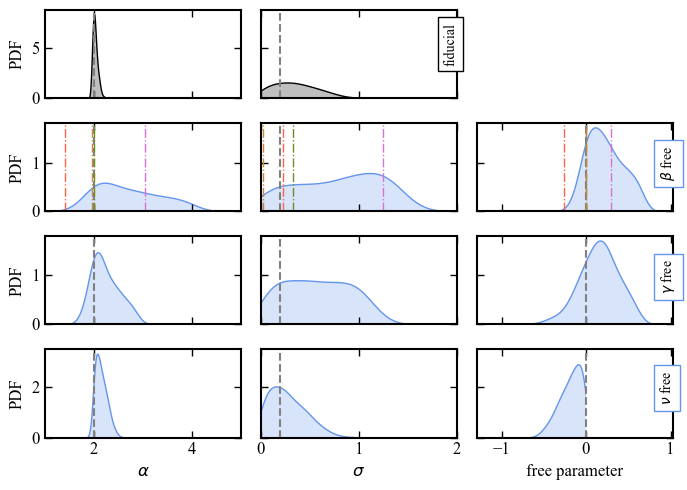

In [20]:
# Create a 4x3 subplot grid
fig, axes = plt.subplots(4, 3, sharex="col", sharey="row", figsize=(double_textwidth, 5))

# Loop through each subplot and plot KDE of the corresponding parameter
sns.kdeplot(standard.clean[:, 0], ax=axes[0,0], bw_adjust=2, fill=True, color="k")
sns.kdeplot(standard.clean[:, 1], ax=axes[0,1], bw_adjust=2, fill=True, color="k")
axes[0,2].axis("off")
axes[0,1].text(0.93, 0.4, "fiducial", rotation=90, transform=axes[0,1].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="k"))

axes[0,0].set_ylabel("PDF")

sns.kdeplot(beta.clean[:, 0], ax=axes[1,0], bw_adjust=2, fill=True, color="cornflowerblue")
sns.kdeplot(beta.clean[:, 2], ax=axes[1,1], bw_adjust=2, fill=True, color="cornflowerblue")
sns.kdeplot(beta.clean[:, 1], ax=axes[1,2], bw_adjust=2, fill=True, color="cornflowerblue")
axes[1,2].text(0.93, 0.4, "$\\beta$ free", rotation=90, transform=axes[1,2].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="cornflowerblue"))
axes[1,0].set_ylabel("PDF")


sns.kdeplot(gamma.clean[:, 0], ax=axes[2,0], bw_adjust=2, fill=True, color="cornflowerblue")
sns.kdeplot(gamma.clean[:, 2], ax=axes[2,1], bw_adjust=2, fill=True, color="cornflowerblue")
sns.kdeplot(gamma.clean[:, 1], ax=axes[2,2], bw_adjust=2, fill=True, color="cornflowerblue")
axes[2,2].text(0.93, 0.4, "$\\gamma$ free", rotation=90, transform=axes[2,2].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="cornflowerblue"))
axes[2,0].set_ylabel("PDF")

sns.kdeplot(nu.clean[:, 0], ax=axes[3,0], bw_adjust=2, fill=True, color="cornflowerblue")
sns.kdeplot(nu.clean[:, 1], ax=axes[3,1], bw_adjust=2, fill=True, color="cornflowerblue")
sns.kdeplot(nu.clean[:, 2], ax=axes[3,2], bw_adjust=2, fill=True, color="cornflowerblue")
axes[3,2].text(0.93, 0.4, "$\\nu$ free", rotation=90, transform=axes[3,2].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="cornflowerblue"))
axes[3,0].set_ylabel("PDF")

axes[3,0].set_xlim(1, 5)
axes[3,1].set_xlim(0, 2)

axes[3,0].set_xlabel("$\\alpha$")
axes[3,1].set_xlabel("$\\sigma$")
axes[3,2].set_xlabel("free parameter")

for index, ax in enumerate(axes[:,0]):
    ax.axvline(2.0, ls="--", color="grey",lw=1.5)
for index, ax in enumerate(axes[:,1]):
    ax.axvline(0.2, ls="--", color="grey",lw=1.5)
for index, ax in enumerate(axes[1:,2]):
    ax.axvline(0.0, ls="--", color="grey",lw=1.5)

for index, theta in enumerate(theta_picks):
    axes[1,0].axvline(theta[1], ls="-.", color=new_colors[index], lw=1)
    axes[1,1].axvline(theta[4], ls="-.", color=new_colors[index], lw=1)
    axes[1,2].axvline(theta[2], ls="-.", color=new_colors[index], lw=1)

rect = patches.Rectangle((0, 0), 1, 2, linewidth=1, edgecolor='none', facecolor='white')
axes[3,2].add_patch(rect)


plt.tight_layout()
plt.savefig("../../../paper_1/figures/feature_recovery/extra_freedom.pdf", bbox_inches="tight")
plt.show()


In [164]:
from astropy.table import QTable

dof = [2, 3, 3, 3]

free_parameter = [" - ", "$\\beta$", "$\\gamma$", "$\\nu$"]

in_alphas = ["2.0"] * 4
in_sigmas = ["0.2"] * 4
in_free = ["0.0"] * 4

out_alphas = [standard.constraints[0], beta.constraints[0], gamma.constraints[0], nu.constraints[0]]

out_sigmas = [standard.constraints[1], beta.constraints[2], gamma.constraints[2], nu.constraints[1]]

out_free = [" - ", beta.constraints[1], gamma.constraints[1], nu.constraints[2]]

In [165]:
tab = QTable([free_parameter, dof, in_alphas, in_sigmas, in_free, out_alphas, out_sigmas, out_free])
tab.write(filename="../../../paper_1/test.txt", format="latex", overwrite=True)

In [67]:
# mass_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"][0]
# red_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"][0]
# halo_masses = np.linspace(9,12,100) # just for the model

# data = jsm_models.LOAD_DATA("../../mcmc/simple_power_law/s15/alpha_permutations/mock_1/mock_data.npz")
# data.get_stats(min_mass=6.5, max_N=700)

# def SHMR_plot(thetas, model_colors, model_names):

#     fig, axs = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(single_textwidth, 7))
    
#     for i,theta in enumerate(thetas):

#         axs[i].scatter(data.lgMh_data.flatten()[data.lgMs_data.flatten() > 6.5], data.lgMs_data.flatten()[data.lgMs_data.flatten() > 6.5], marker="*", color="k", s=8)
#         axs[i].scatter(data.lgMh_data.flatten()[data.lgMs_data.flatten() < 6.5], data.lgMs_data.flatten()[data.lgMs_data.flatten() < 6.5], marker=".", color="grey", s=4)

#         theta_det = [theta[0], theta[1], theta[2], theta[3], 0.0, 0.0]
#         det = jsm_SHMR.general_new(theta_det, halo_masses, 0, 1)
#         sigma = theta[4] + theta[5]*(halo_masses-12)

#         axs[i].plot(halo_masses, det, color=model_colors[i], label=model_names[i], lw=2)
#         axs[i].axhline(6.5, color="grey", ls=":")
#         axs[i].legend(loc=2)
#         axs[i].set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")

#         if i==2:
#             z_max = 3
#             deterministic_early = jsm_SHMR.general_new(theta_det, halo_masses, z_max, 1)
#             if deterministic_early[0] > det[0]:
#                 axs[i].fill_between(halo_masses, deterministic_early + sigma, det - sigma, color=model_colors[i], alpha=0.25)

#         else:
#             axs[i].fill_between(halo_masses, det - sigma, det + sigma, color=model_colors[i], alpha=0.25) 
 


#     axs[3].set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$")
#     axs[0].set_ylim(5.5, 10.5)
#     axs[0].set_xlim(9.0, 12)
#     plt.tight_layout()
#     #plt.savefig('../../../paper_1/figures/updated/extra_freedom_SHMR.pdf', bbox_inches="tight")
#     plt.show()

# thetas = [[10.5, 2.01, 0.0, 0.0, 0.33, 0.0], [10.5, 2.59, 0.2, 0.0, 0.84, 0.0], [10.5, 2.26, 0.0, 0.22, 0.66, 0.0], [10.5, 2.12, 0.0, 0.0, 0.24, -0.16]]

# model_colors = ["steelblue", 'olivedrab', 'darkviolet', 'firebrick']

# model_names = ["fiducial", "$\\beta$ free", "$\\gamma$ free", "$\\nu$ free"]

# SHMR_plot(thetas, model_colors, model_names)

In [10]:
# new_colors = ["olivedrab", "tomato", "peru", "orchid"]
# theta_picks = [[10.5, 2.01, 0.0, 0.0, 0.33, 0.0], [10.5,  1.41833432, -0.26605046,  0.0,  0.22950717,0.0], [1.05000000e+01, 1.95386648e+00, 8.03348913e-05, 0.00000000e+00, 2.13869347e-02, 0.00000000e+00], [10.5,3.0422462 ,0.30028834,  0.,  1.24455193,0.]]

In [11]:
# # Remove ticks from the top and bottom of the plot
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['xtick.top'] = False

# # Define quantiles
# qaunts = [0.16, 0.5, 0.84]

# # Define violin plot function
# def violin_plot(ax, data, quantiles, color, ylim=None):
#     violin = ax.violinplot(data, showmedians=True, showextrema=True)#, quantiles=quantiles)
#     for pc in violin['bodies']:
#         pc.set_facecolor('grey')
#         pc.set_edgecolor('black')
#     for partname in ('cmins', 'cmaxes', 'cbars', 'cmedians'):
#         vp = violin[partname]
#         vp.set_edgecolor(color if partname == 'cmedians' else 'grey')
#         vp.set_linewidth(2.5 if partname == 'cmedians' else 1)
#     if ylim is not None:
#         ax.set_ylim(ylim)

# truth_color = "grey"

# # Create subplots
# fig, axs = plt.subplots(ncols=4, nrows=3, sharex=True, figsize=(single_textwidth, single_textwidth))

# # Plot violins
# violin_plot(axs[0, 0], standard.clean[:,0], qaunts, 'black', (1.2, 4.5))
# axs[0,0].axhline(2.0, color=truth_color, ls="--")
# violin_plot(axs[1, 0], standard.clean[:,1], qaunts, 'black', (0, 1.85))
# axs[1,0].axhline(0.2, color=truth_color, ls="--")

# violin_plot(axs[0, 1], beta.clean[:,0], qaunts, 'black', (1.2, 4.5))
# axs[0,1].axhline(2.0, color=truth_color, ls="--")
# violin_plot(axs[1, 1], beta.clean[:,2], qaunts, 'black', (0, 1.85))
# axs[1,1].axhline(0.2, color=truth_color, ls="--")
# violin_plot(axs[2, 1], beta.clean[:,1], qaunts, 'black')
# axs[2,1].axhline(0.0, color=truth_color, ls="--")

# for ii in range(len(theta_picks)):
#     axs[0,1].axhline(theta_picks[ii][1], color=new_colors[ii], ls=":", zorder=10, lw=2)
#     axs[1,1].axhline(theta_picks[ii][4], color=new_colors[ii], ls=":", zorder=10, lw=2)
#     axs[2,1].axhline(theta_picks[ii][2], color=new_colors[ii], ls=":", zorder=10, lw=2)


# violin_plot(axs[0, 2], gamma.clean[:,0], qaunts, 'black', (1.2, 4.5))
# axs[0,2].axhline(2.0, color=truth_color, ls="--")
# violin_plot(axs[1, 2], gamma.clean[:,1], qaunts, 'black', (0, 1.85))
# axs[1,2].axhline(0.2, color=truth_color, ls="--")
# violin_plot(axs[2, 2], gamma.clean[:,2], qaunts, 'black')
# axs[2,2].axhline(0.0, color=truth_color, ls="--")


# violin_plot(axs[0, 3], nu.clean[:,0], qaunts, 'black', (1.2, 4.5))
# axs[0,3].axhline(2.0, color=truth_color, ls="--")
# violin_plot(axs[1, 3], nu.clean[:,1], qaunts, 'black', (0, 1.85))
# axs[1,3].axhline(0.2, color=truth_color, ls="--")
# violin_plot(axs[2, 3], nu.clean[:,2], qaunts, 'black')
# axs[2,3].axhline(0.0, color=truth_color, ls="--")


# # violin_plot(axs[0, 4], anchor.clean[:,1], qaunts, 'peru', (1.2, 4.5))
# # axs[0,4].axhline(2.0, color=truth_color, ls="--")
# # violin_plot(axs[1, 4], anchor.clean[:,2], qaunts, 'peru', (0, 1.85))
# # axs[1,4].axhline(0.2, color=truth_color, ls="--")
# # violin_plot(axs[2, 4], anchor.clean[:,0], qaunts, 'peru')
# # axs[2,4].axhline(10.5, color=truth_color, ls="--")


# # Customize axes and labels
# axs[2, 1].tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)

# axs[2, 2].tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)

# axs[2, 3].tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)

# # axs[2, 4].tick_params(
# #     axis='x',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom=False,      # ticks along the bottom edge are off
# #     top=False,         # ticks along the top edge are off
# #     labelbottom=False)


# axs[1, 0].set_xlabel("fiducial")
# axs[2, 1].set_xlabel("$\\beta$ free")
# axs[2, 2].set_xlabel("$\\gamma$ free")
# axs[2, 3].set_xlabel("$\\nu$ free")
# #axs[2, 4].set_xlabel("$M_{*,0}$ free")


# axs[0, 0].set_ylabel("$\\alpha$")
# axs[1, 0].set_ylabel("$\\sigma$")
# # axs[2, 2].set_ylabel("$\\gamma$")
# # axs[2, 3].set_ylabel("$\\nu$")
# # axs[2, 4].set_ylabel("$M_{*,0}$")

# # Remove ticks from the top and bottom of the plot
# axs[2,0].axis("off")
# plt.tight_layout(w_pad=0, h_pad=0)
# #plt.savefig("../../../paper_1/figures/feature_recovery/extra_freedom.pdf", bbox_inches="tight")
# plt.show()